# Advanced network consolidation

## Refactored version for development purposes

1. consolidate intersections
2. consolidate edges

TODO:

- [ ] false planarity
- [ ] figure out clever way of adaptable filters (to identify which polygons should not be there, i.e. which edges should be consolidated)
- [ ] triple/quadruple lines

Future:

- [ ] implementation into OSMnx
- [ ] make it work for both GeoDataFrames and Graph

In [1]:
from itertools import combinations
import collections

import pygeos
import numpy as np
import pandas as pd
import geopandas as gpd
import momepy as mm
import osmnx as ox
import contextily as ctx

from shapely.ops import polygonize
from scipy.spatial import Voronoi
from sklearn.cluster import KMeans
from sklearn import preprocessing
from clustergram import Clustergram

from consolidate import *
from consolidate import _average_geometry

## Load data

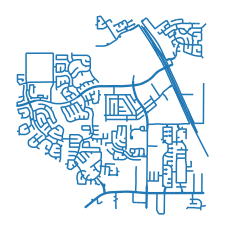

In [2]:
point = (30.027555, -95.615635)
dist = 2000

streets_graph = ox.graph_from_point(point, dist, network_type='drive')
streets_graph = ox.projection.project_graph(streets_graph)
gdf = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
gdf.plot().set_axis_off()

## Consolidate nodes

The process of node consolidation based on DBSCAN is relatively straightforward and stable.

The `consolidate_nodes` function returns consolidated network and newly derived nodes.

In [3]:
%%time
cons_nodes, midpoints = consolidate_nodes(gdf, tolerance=20)

CPU times: user 574 ms, sys: 96.4 ms, total: 671 ms
Wall time: 520 ms


<AxesSubplot:>

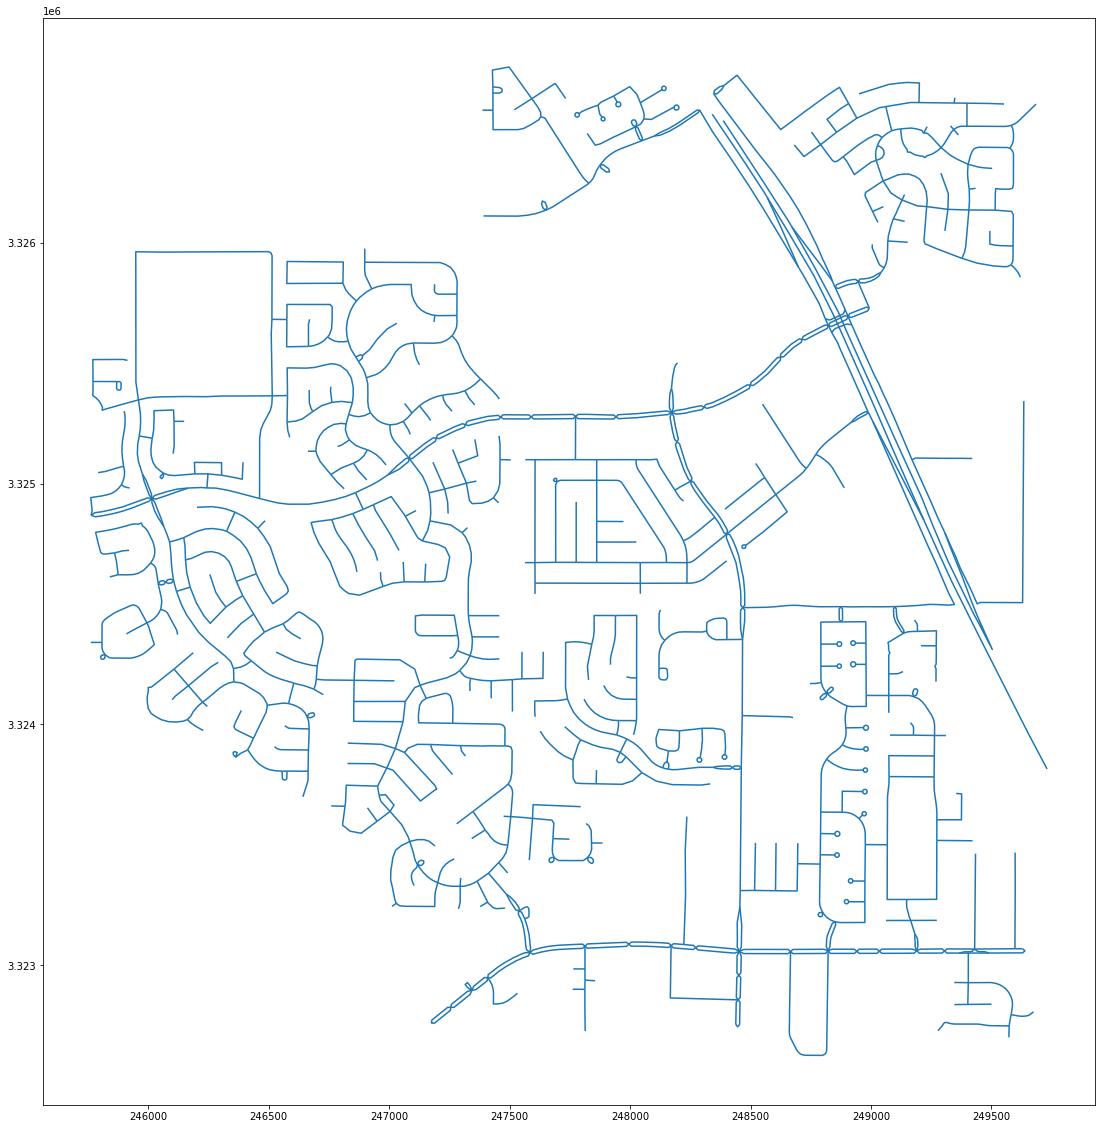

In [16]:
cons_nodes.plot(figsize=(20, 20))

## Consolidate edges

1. Polygonize
2. Select polygons which should be removed
3. Generate average geometry

To preserve planarity (do not create artificial intersections), this schema needs to be a bit more complex.

### Polygonize

In [4]:
network = cons_nodes

In [5]:
# polygonize network
polygonized = polygonize(network.geometry.unary_union)
polygons = gpd.GeoDataFrame(geometry=[g for g in polygonized], crs=network.crs)

### Generate mask

In [6]:
polygons['area'] = polygons.area
# polygons['perimeter'] = polygons.length
polygons['circom'] = mm.CircularCompactness(polygons, 'area').series
# polygons['cwa'] = mm.CompactnessWeightedAxis(polygons, 'area',).series
# polygons['convexity'] = mm.Convexity(polygons, 'area').series
# polygons['corners'] = mm.Corners(polygons, verbose=False).series
# polygons['elongation'] = mm.Elongation(polygons).series
# polygons['eri'] = mm.EquivalentRectangularIndex(polygons,).series

In [52]:
def filter_small(gdf, network, max_size=1000):
    """
    Identify small polygons enclosed by multiple geometries (keeps roundabout at the end of the cul-de-sac)
    """
    small = gdf[gdf.area < max_size]
    inp, res = pygeos.STRtree(small.geometry.values.data).query_bulk(network.geometry.values.data, predicate='covered_by')
    unique, counts = np.unique(res, return_counts=True)
    return gdf.index.isin(small.iloc[unique[counts>1]].index)

In [53]:
m1 = (polygons["area"] < 8000) & (polygons["circom"] < 0.2)
m2 = filter_small(polygons, network, 2000)

In [57]:
mask = m1 | m2

<AxesSubplot:>

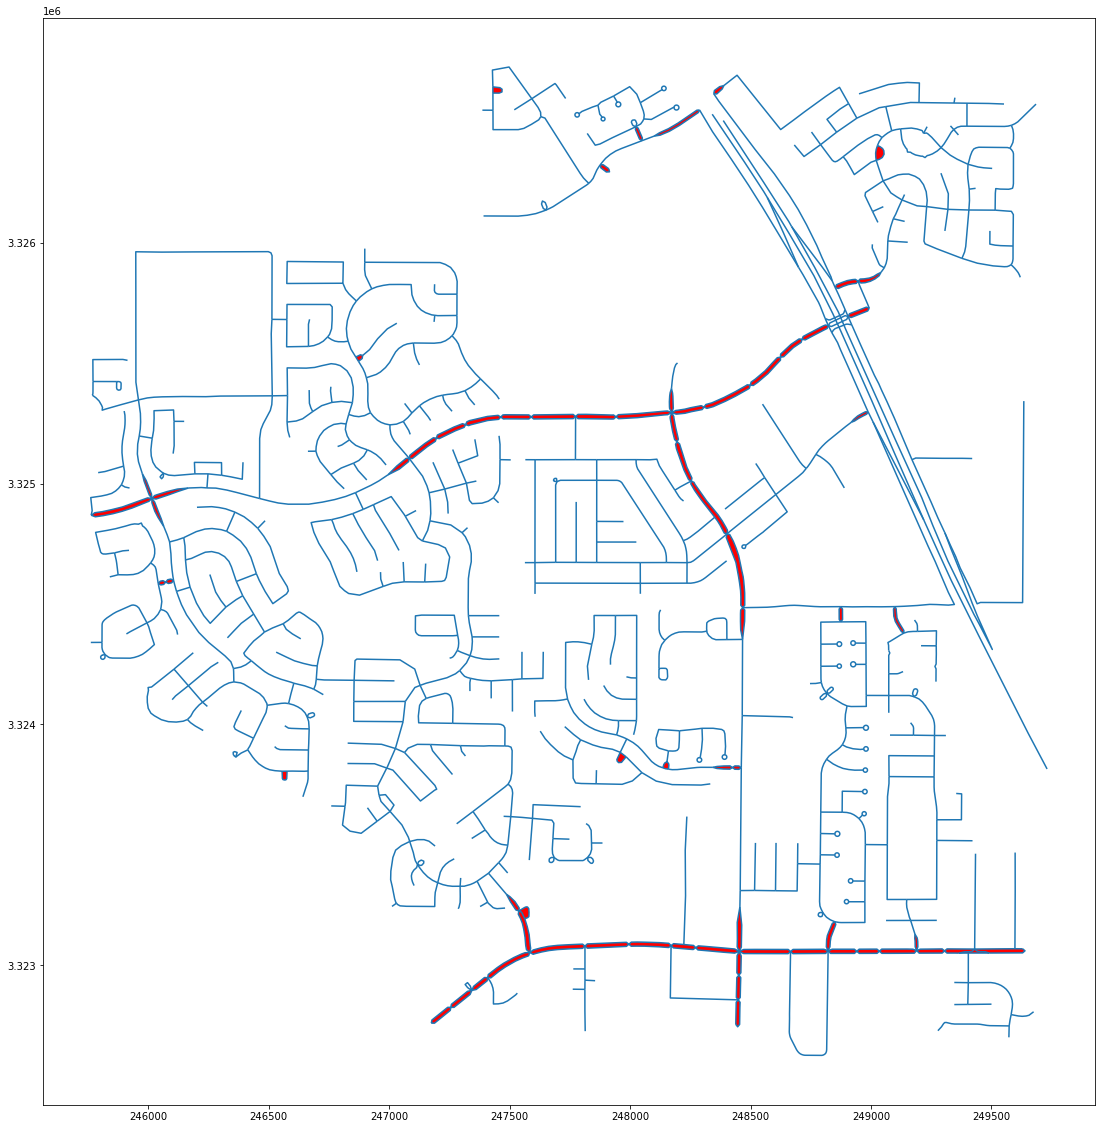

In [60]:
ax = polygons[mask].plot(figsize=(20, 20),color='r')
cons_nodes.plot(ax=ax)

### Simplify network

In [61]:
distance = 2
epsilon = 2

In [62]:

invalid = polygons.loc[mask, 'geometry']

sindex = network.sindex

# iterate over polygons which are marked to be consolidated
# list segments to be removed and the averaged geoms replacing them
averaged = []
to_remove = []
for poly in invalid:
#     real = network.iloc[sindex.query(poly.exterior, predicate="intersects")]
#     mask = real.intersection(poly.exterior).type.isin(
#         ["LineString", "MultiLineString"]
#     )
#     real = real[mask]
    
    # temporarily go via pygeos until 0.9 gpd
    real = network.iloc[pygeos.STRtree(network.geometry.values.data).query(pygeos.from_shapely(poly.exterior), predicate='covers')]
    if round(real.length.sum()) == round(poly.length):  # planarity check
        lines = list(real.geometry)
        if lines:
            av = _average_geometry(lines, poly, distance)
            if len(av) > 0:
                to_remove += list(real.index)
                averaged += av

# drop double lines
clean = network.drop(set(to_remove))

# merge new geometries with the existing network
averaged = gpd.GeoSeries(averaged, crs=network.crs).simplify(epsilon).explode()   
result = pd.concat([clean, averaged])

# final result with a clean topology
merge = topology(result)

<AxesSubplot:>

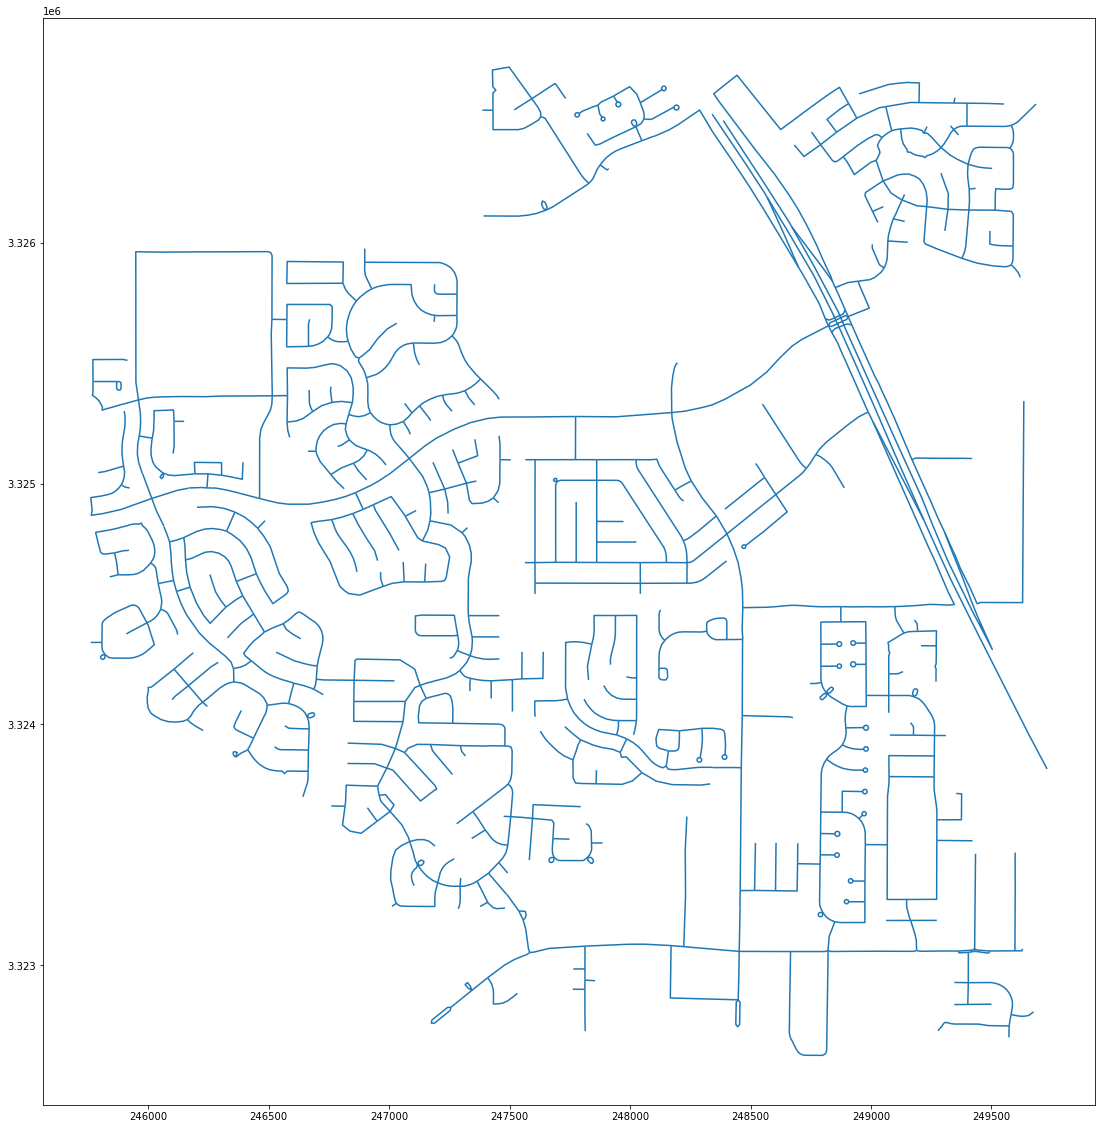

In [63]:
merge.plot(figsize=(20,20))

<AxesSubplot:>

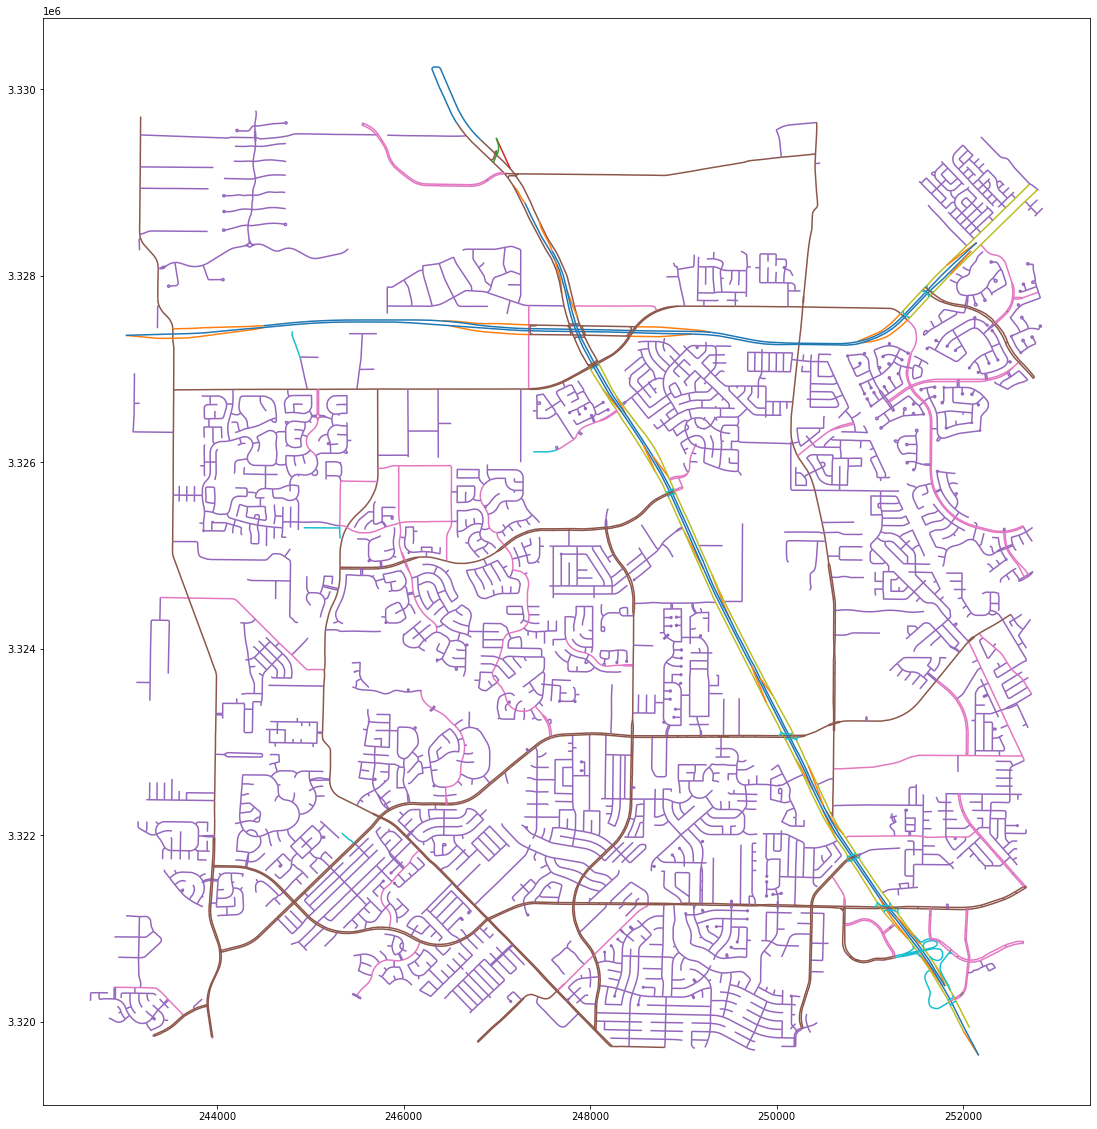

In [64]:
point = (30.027555, -95.615635)
dist = 5000

streets_graph = ox.graph_from_point(point, dist, network_type='drive')
streets_graph = ox.projection.project_graph(streets_graph)
gdf = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
gdf.plot(gdf.highway.astype(str), figsize=(20, 20))

In [65]:
cons_nodes, midpoints = consolidate_nodes(gdf, tolerance=20)

In [72]:
network = cons_nodes

# polygonize network
polygonized = polygonize(network.geometry.unary_union)
polygons = gpd.GeoDataFrame(geometry=[g for g in polygonized], crs=network.crs)
polygons['area'] = polygons.area
polygons['circom'] = mm.CircularCompactness(polygons, 'area').series

m1 = (polygons["area"] < 10000) & (polygons["circom"] < 0.2)
m2 = filter_small(polygons, network, 2000)

mask = m1 | m2

<AxesSubplot:>

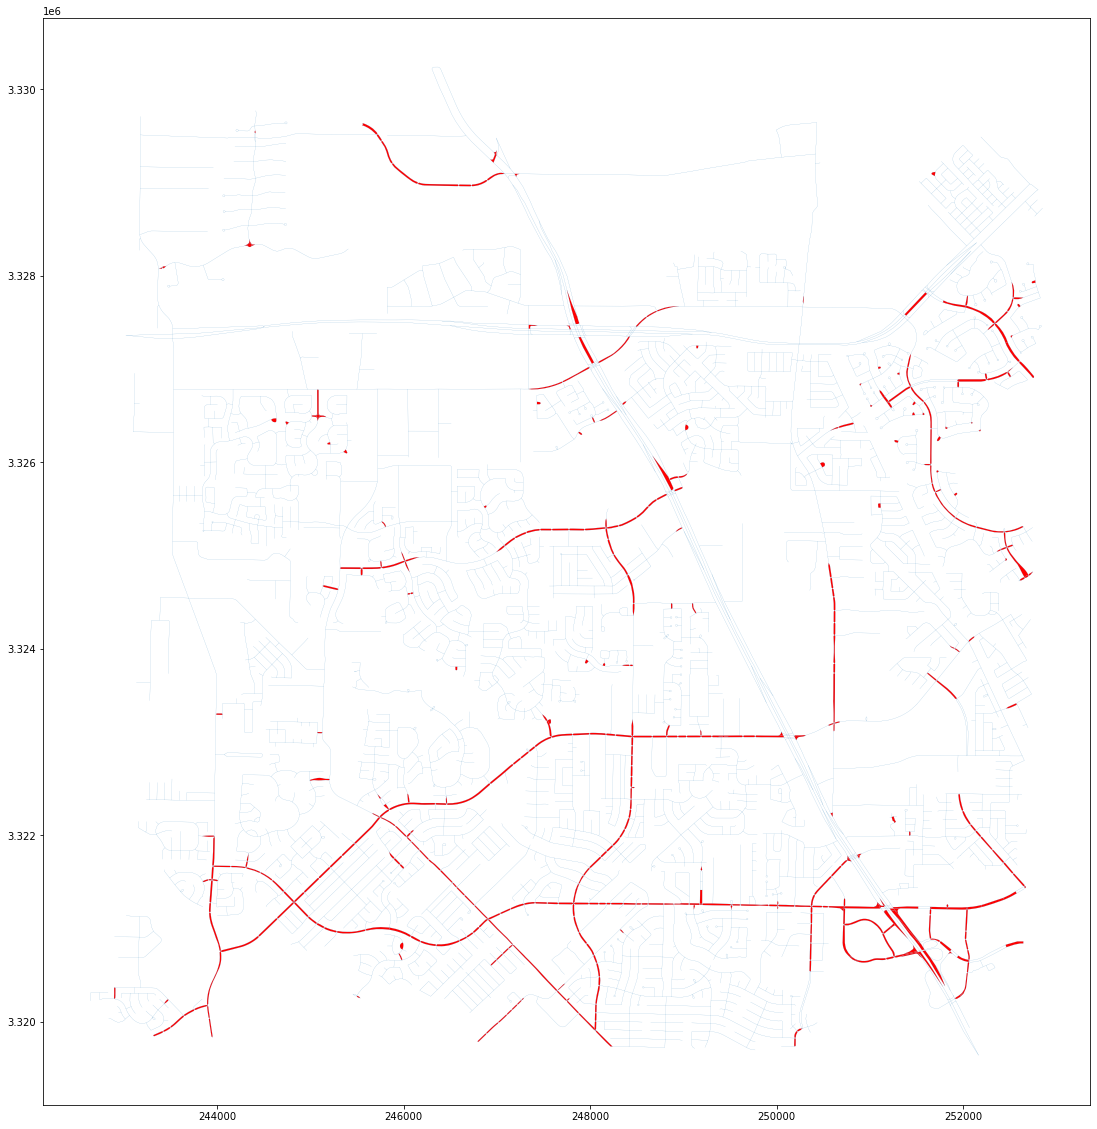

In [73]:
ax = polygons[mask].plot(figsize=(20, 20),color='r', zorder=2)
cons_nodes.plot(ax=ax, linewidth=.1)

In [74]:
invalid = polygons.loc[mask, 'geometry']

sindex = network.sindex

# iterate over polygons which are marked to be consolidated
# list segments to be removed and the averaged geoms replacing them
averaged = []
to_remove = []
for poly in invalid:
#     real = network.iloc[sindex.query(poly.exterior, predicate="intersects")]
#     mask = real.intersection(poly.exterior).type.isin(
#         ["LineString", "MultiLineString"]
#     )
#     real = real[mask]
    
    # temporarily go via pygeos until 0.9 gpd
    real = network.iloc[pygeos.STRtree(network.geometry.values.data).query(pygeos.from_shapely(poly.exterior), predicate='covers')]
    if round(real.length.sum()) == round(poly.length):  # planarity check
        lines = list(real.geometry)
        if lines:
            av = _average_geometry(lines, poly, distance)
            if len(av) > 0:
                to_remove += list(real.index)
                averaged += av

# drop double lines
clean = network.drop(set(to_remove))

# merge new geometries with the existing network
averaged = gpd.GeoSeries(averaged, crs=network.crs).simplify(epsilon).explode()   
result = pd.concat([clean, averaged])

# final result with a clean topology
merge = topology(result)

<AxesSubplot:>

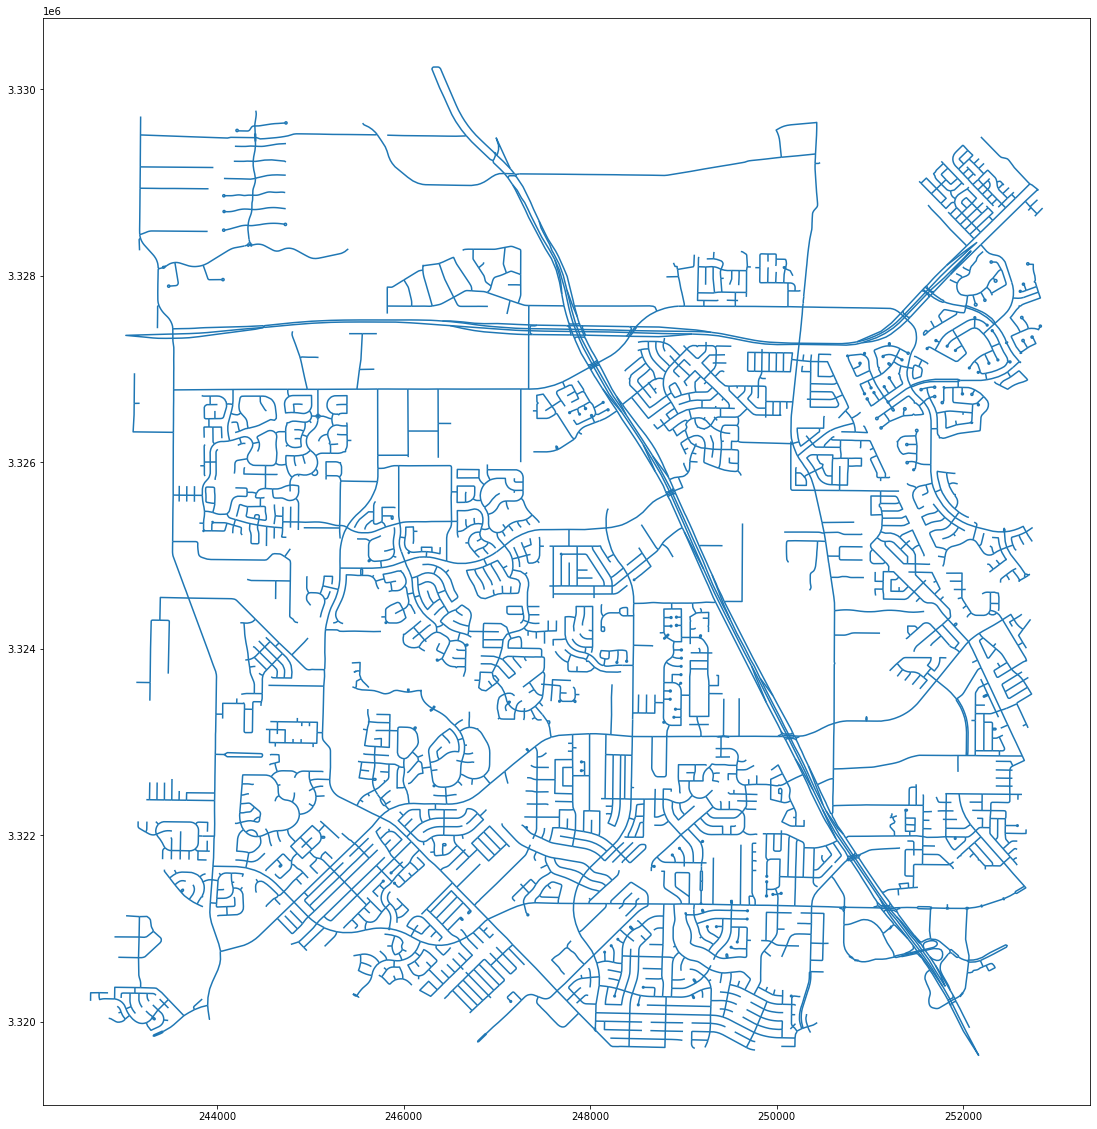

In [75]:
merge.plot(figsize=(20,20))